In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn

In [ ]:
df_holiday= pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\holidays_events.csv')
df_oil = pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\oil.csv')
df_store = pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\stores.csv')
df_train = pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\train.csv')
df_test = pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\/test.csv')
df_transactions = pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\transactions.csv')
df_sample_submission = pd.read_csv('C:\\Users\\deni\\Downloads\\competition\\sample_submission.csv')


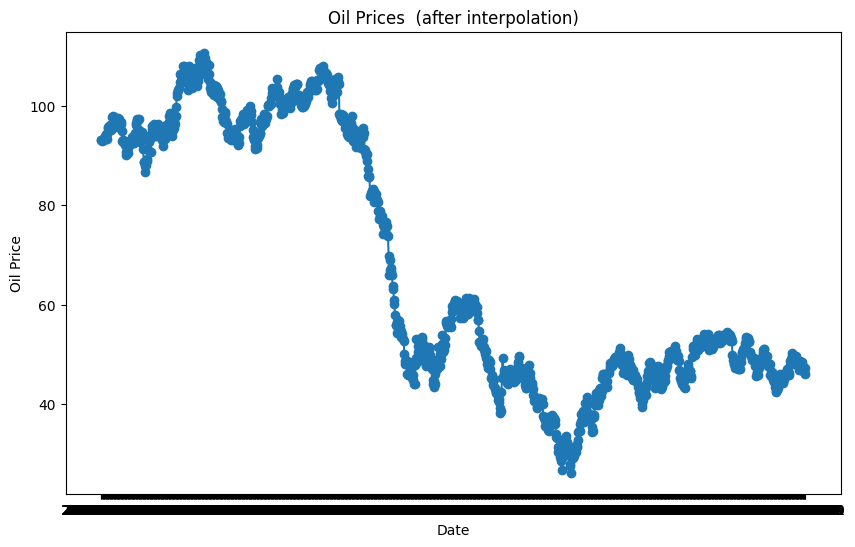

In [ ]:
    df_oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
#Filling the missing oil values using the linear interpolation function of pandas
df_oil['oil_price'].interpolate(method='linear', inplace=True)

df_oil.at[0, 'oil_price'] = df_oil.at[1, 'oil_price']
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['oil_price'], marker='o', linestyle='-')
plt.title('Oil Prices  (after interpolation)')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

In [ ]:
#A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
df_holiday[(df_holiday['transferred'] == True) | (df_holiday['type'] == 'Transfer')]
#Because the competition tells us a holiday that is transferred should be treated like a normal day, we will change the type to normal so it does not affect our data. Days that have type 'Transfer' will be treated as regular holidays.
df_holiday.loc[df_holiday['transferred'], 'type'] = 'Normal'
df_holiday.loc[df_holiday['type'] == 'Transfer', 'type'] = 'Holiday'
df_holiday.loc[df_holiday['type'] == 'Bridge', 'type'] = 'Holiday'
df_holiday.drop('transferred', axis=1, inplace=True)
df_holiday


,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3
346,2017-12-23,Additional,National,Ecuador,Navidad-2
347,2017-12-24,Additional,National,Ecuador,Navidad-1
348,2017-12-25,Holiday,National,Ecuador,Navidad


In [ ]:
  # Convert all columns to datetime
  df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
  df_holiday['date'] = pd.to_datetime(df_holiday['date'], format = '%Y-%m-%d')
  df_oil['date'] = pd.to_datetime(df_oil['date'], format = '%Y-%m-%d')
  df_test['date'] = pd.to_datetime(df_test['date'], format = '%Y-%m-%d')
  df_transactions['date'] = pd.to_datetime(df_transactions['date'], format = '%Y-%m-%d')

In [ ]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Text(0, 0.5, 'Number of sales')

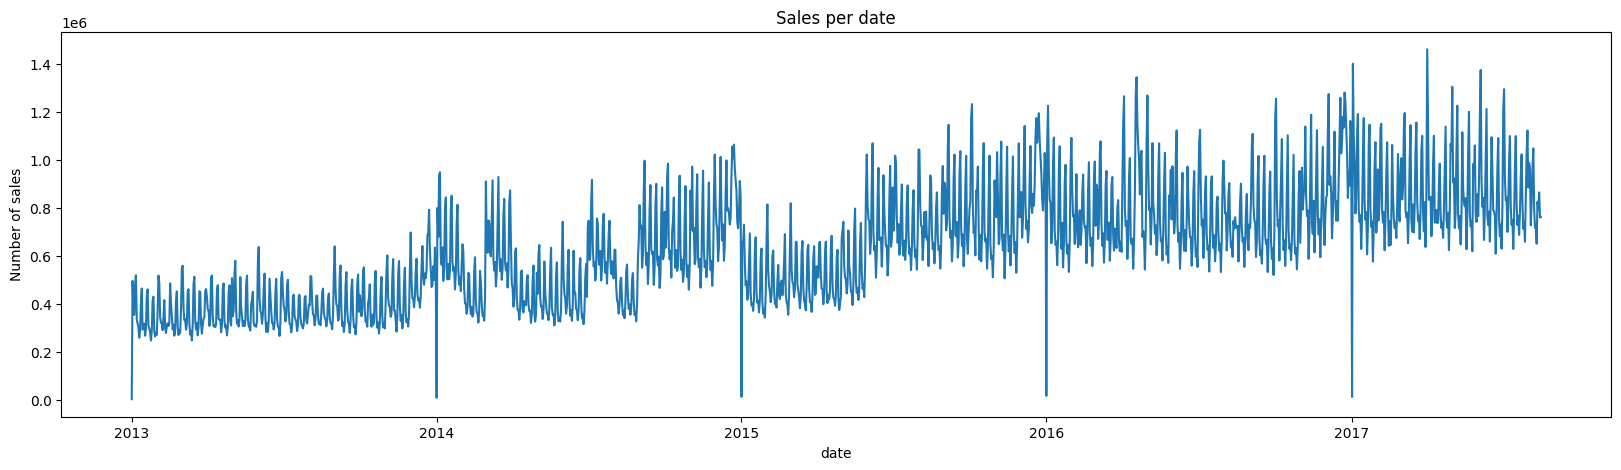

In [ ]:
plt.figure(figsize = (20,5))
sns.lineplot(df_train.groupby('date').sum()['sales'])
plt.title('Sales per date')
plt.xlabel('date')
plt.ylabel('Number of sales')

In [ ]:
def join_dfs(df_train, df_oil, df_holiday, df_store):
    # merging oil prices with the dataframe
    merged_df = pd.merge(df_train, df_oil, on='date')
    # merging holidays with the dataframe
    merged_df = pd.merge(merged_df, df_holiday, on='date', how='left')
    # filling missing values
    merged_df = merged_df.fillna("None")
    # merging the store data with the dataframe
    merged_df = pd.merge(merged_df, df_store, on='store_nbr', how='left')

    return merged_df

In [ ]:
merged_df = join_dfs(df_train, df_oil, df_holiday, df_store)
merged_df.isna().sum() # no missing values

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
oil_price      0
type_x         0
locale         0
locale_name    0
description    0
city           0
state          0
type_y         0
cluster        0
dtype: int64

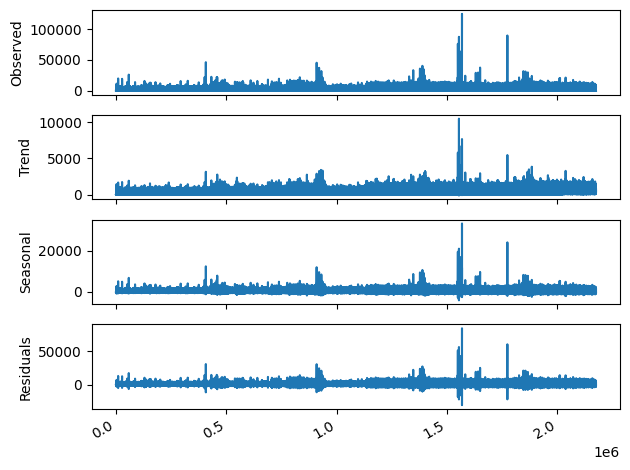

In [ ]:
# checking trend seasonality and residuals Buse   https://github.com/busekoseoglu/time-series-forecasting/blob/main/google_closing_article_1.ipynb
df=merged_df
from statsmodels.tsa.seasonal import seasonal_decompose, STL
advanced_decomposition = STL(df.sales, period=16 ).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)
ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
df.head()

In [ ]:
 df.tail()

In [ ]:
df_train.head()

In [ ]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
#p-value < threshold value (e.g., 0.01, 0.05, etc.), we can reject the null hypothesis and conclude that the data is stationary
result = adfuller(df.sales, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

MemoryError: Unable to allocate 2.38 GiB for an array with shape (2175967, 147) and data type float64

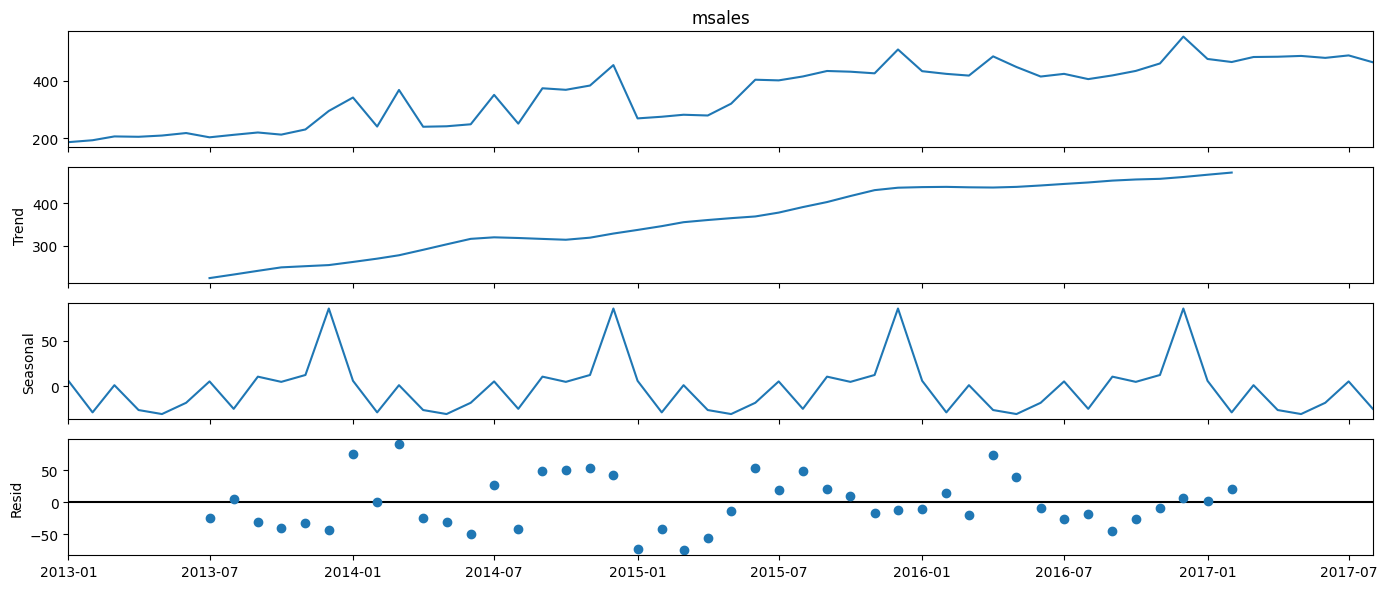

In [ ]:
# checking trend seasonality and residuals
import statsmodels.api as sm
t_series = df_train.groupby(['date'])['sales'].agg(['mean']).reset_index().rename(columns={'mean': 'msales'})
t_series = t_series.set_index('date')
sample= t_series['msales'].resample('MS').mean()
decomposition = sm.tsa.seasonal_decompose(sample, model='additive')
fig = decomposition.plot()
fig.set_size_inches((14, 6))
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
pip install git+git://github.com/AutoViML/Auto_TS

  Cloning git://github.com/AutoViML/Auto_TS to c:\users\deni\appdata\local\temp\pip-req-build-60445bco
Note: you may need to restart the kernel to use updated packages.


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
